In [34]:
from scipy.io import loadmat
import numpy as np
import mne
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [35]:
# 1. Load the .mat file
data = loadmat('sampleEEGdata.mat')
EEG = data['EEG']
eeg_data = EEG['data'][0, 0] #eeg_data.shape=(64, 640, 99), [channels:64, time points:640, trials:99]
times = EEG['times'][0, 0][0] #times.shape= (640,)
print('EEG.shape:', EEG.shape) #EEG.shape: (1, 1)
print('eeg_data.shape:', eeg_data.shape) #EEG.shape: (1, 1)
print('times.shape:', times.shape) #EEG.shape: (1, 1)
microvolt = "µV"


EEG.shape: (1, 1)
eeg_data.shape: (64, 640, 99)
times.shape: (640,)


In [30]:
# def perform_pca(eeg_data_epoch):
#     # Reshape data to (channels, time_points * trials)
#     n_channels, n_times, n_trials = eeg_data_epoch.shape
#     eeg_data_reshaped = eeg_data_epoch_B.transpose(2, 1, 0)

#     # Center the data by subtracting the mean across the concatenated time points
#     eeg_data_centered = eeg_data_reshaped - np.mean(eeg_data_reshaped, axis=1, keepdims=True)

#     # Calculate the covariance matrix of the centered data
#     covariance_matrix = np.cov(eeg_data_centered)

#     # Perform eigenvalue decomposition on the covariance matrix
#     eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

#     # Order the PCs and the eigenvalues in descending order
#     idx = eigenvalues.argsort()[::-1]
#     eigenvalues = eigenvalues[idx]
#     pcs = eigenvectors[:, idx]

#     return pcs, eigenvalues


In [36]:
######################################################################################################################################################
# a.1. Extract Epochs 
eeg_data_epoch_B= eeg_data[:, 128:256, :] # shape: (64, 128, 99)
eeg_data_epoch_A= eeg_data[:, 282:410, :] # shape: (64, 128, 99)

###############################################################################################################################################
# Function to perform PCA on the data
def perform_pca(eeg_data_epoch):
    eeg_data_reshaped = eeg_data_epoch.transpose(2, 1, 0)
    # Center the data by subtracting the mean of each epoch
    eeg_data_centered = eeg_data_reshaped - np.mean(eeg_data_epoch, axis=1, keepdims=True)
    # Initialize a list to store covariance matrices for each trial
    cov_matrices = []
    # Calculate the sample covariance matrix for each trial and store it
    for trial in eeg_data_centered:
        covariance_matrix = np.cov(trial, rowvar=False)
        cov_matrices.append(covariance_matrix)
    # Calculate the average covariance matrix over all trials
    avg_cov_matrix = np.mean(cov_matrices, axis=0)
    # Perform eigenvalue decomposition on the average covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(avg_cov_matrix)
    # Order the PCs and the eigenvalues in descending order
    idx = eigenvalues.argsort()[::-1]   
    eigenvalues = eigenvalues[idx]
    pcs = eigenvectors[:,idx]
    return pcs, eigenvalues


# Perform PCA on both epochs
pcs_B, eigenvalues_B = perform_pca(eeg_data_epoch_B)
pcs_A, eigenvalues_A = perform_pca(eeg_data_epoch_A)

# The shapes of the resulting PCs and eigenvalues
print(pcs_B.shape, eigenvalues_B.shape)
print(pcs_A.shape, eigenvalues_A.shape)

ValueError: operands could not be broadcast together with shapes (99,128,64) (64,1,99) 

In [24]:

################################################################
# Read the file content
with open('eloc64C2.txt', 'r') as f:
    lines = f.readlines()
# Extract channel names, theta, and radius
channel_names = [line.split()[3].replace('.', '') for line in lines[0:]]  # Skip the header
theta = np.array([float(line.split()[1])-90 for line in lines[0:]]) * np.pi / 180.0  # Convert to radians
radius = np.array([float(line.split()[2]) for line in lines[0:]])
# Convert polar to Cartesian
x = radius * np.cos(theta)/5
y = -radius * np.sin(theta)/5
z = np.zeros_like(x)  # default z-coordinate for all channels
# Create a montage
ch_pos = dict(zip(channel_names, zip(x, y, z)))
montage = mne.channels.make_dig_montage(ch_pos, coord_frame='head')
info = mne.create_info(ch_names=channel_names, sfreq=256, ch_types='eeg')
# Apply the montage to the info
info.set_montage(montage)


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Af7, Af3, F1, F3, F5, F7, Ft7, Fc5, Fc3, Fc1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 256.0 Hz
>

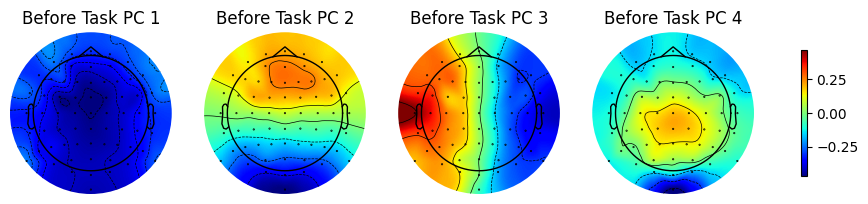

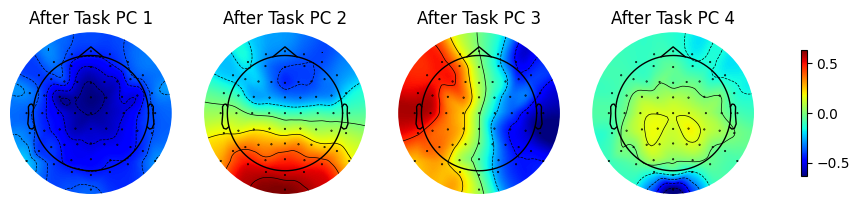

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mne.viz import plot_topomap
from mne import create_info, EvokedArray

# Assuming 'info' is the MNE Info object with 64 EEG channels

# Function to plot topographical maps for the first four components
def plot_topographical_maps(pcs, info, title):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))  # Create a row of 4 subplots
    for i, ax in enumerate(axes):
        evoked = EvokedArray(pcs[:, i, np.newaxis], info, tmin=0)
        im, _ = plot_topomap(evoked.data[:, 0], evoked.info, axes=ax, cmap='jet', show=False)
        ax.set_title(f'{title} PC {i+1}')
    fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
    plt.show()

# Assuming pcs_B and pcs_A are the PCA components with shapes (64, 64)
# Plot topographical maps for the first four components before and after the task
plot_topographical_maps(pcs_B[:, :4], info, "Before Task")
plot_topographical_maps(pcs_A[:, :4], info, "After Task")


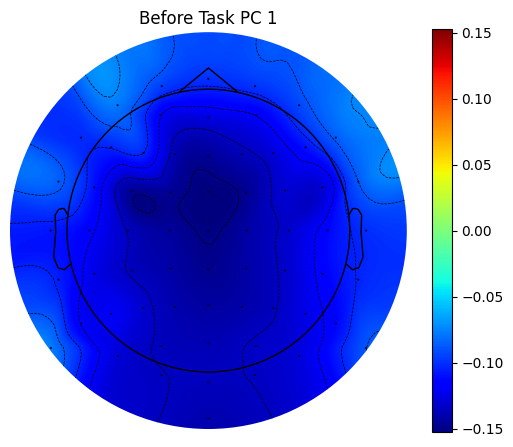

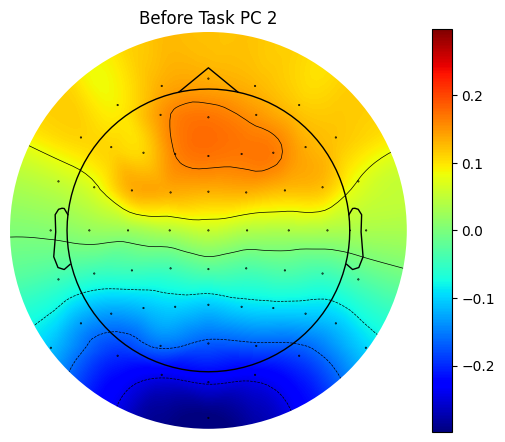

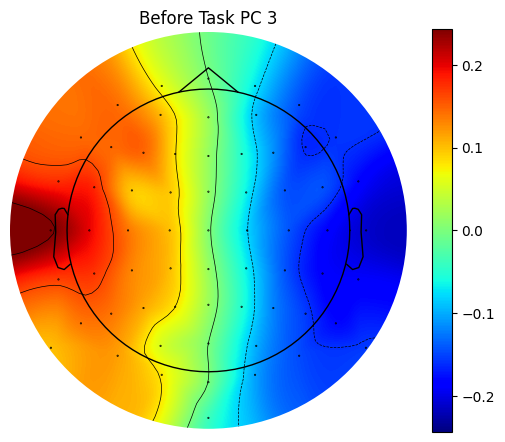

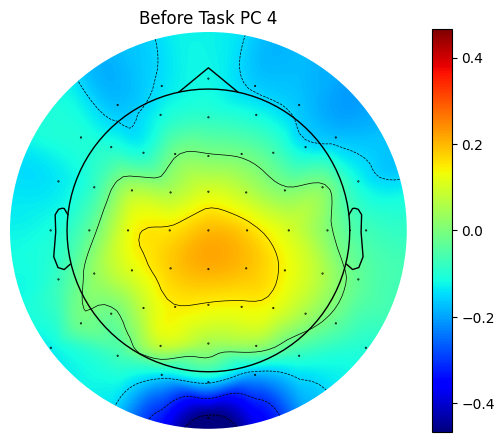

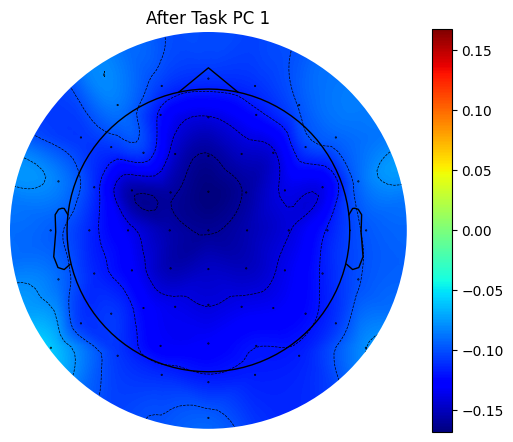

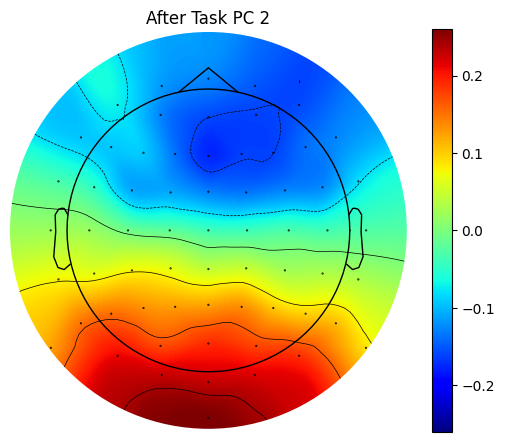

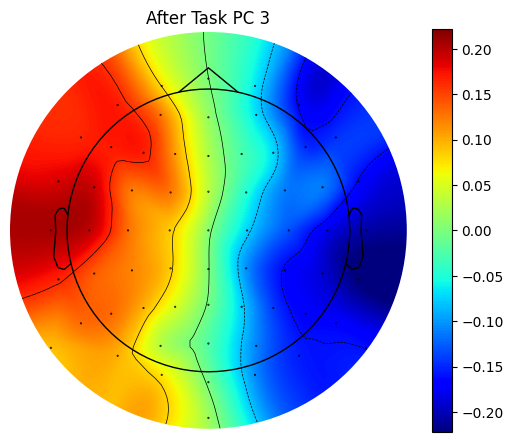

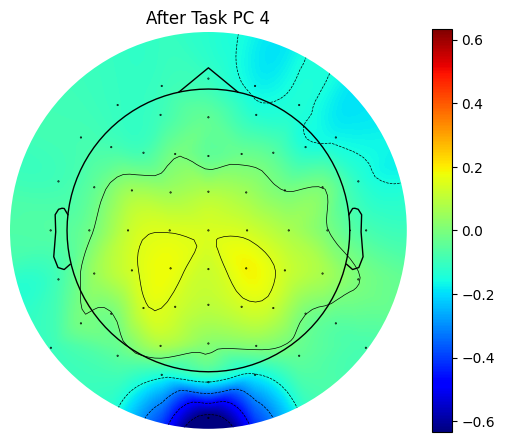

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mne.viz import plot_topomap
from mne.channels import make_standard_montage
from mne import create_info, EvokedArray

# Assuming pcs_B and pcs_A are the PCA components with shapes (64, 64)
# and 'info' is the MNE Info object with 64 EEG channels

# Function to plot topographical maps for the first four components
def plot_topographical_maps(pcs, info, title):
    for i in range(4):  # First four components
        evoked = EvokedArray(pcs[:, i, np.newaxis], info, tmin=0)
        fig, ax = plt.subplots(1)
        im, _ = plot_topomap(evoked.data[:, 0], evoked.info, axes=ax, cmap='jet', show=False)
        ax.set_title(f'{title} PC {i+1}')
        plt.colorbar(im, ax=ax)
        plt.show()

# Plot topographical maps for the first four components before and after the task
plot_topographical_maps(pcs_B[:, :4], info, "Before Task")
plot_topographical_maps(pcs_A[:, :4], info, "After Task")


In [16]:
def plot_topographical_maps(pcs, info, times, title):
    n_components = 4  # Number of components to plot
    n_channels = 64
    
    # Reshape the PCA components to match the number of channels in the Info object
    pcs_reshaped = pcs[:n_channels, :n_components]
    
    for i in range(n_components):
        fig, ax = plt.subplots(1, 1)
        mne.viz.plot_topomap(pcs_reshaped[:, i], info, axes=ax, show=False, cmap='jet')
        ax.set_title(f'{title} PC {i+1}')
        plt.colorbar(mne.viz.plot_topomap(pcs_reshaped[:, i], info, axes=ax, show=False, cmap='jet')[0], ax=ax)
        plt.show()


ValueError: Number of channels in the Info object (64) and the data array (99) do not match. Pick Info with e.g. mne.pick_info and mne.io.pick.channel_indices_by_type.

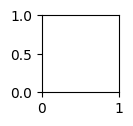

In [15]:
# Function to plot topographical maps for the first four components
def plot_topographical_maps(pcs, info, title):
    for i in range(4):  # First four components
        mne.viz.plot_topomap(pcs[:, i], info, show=False, cmap='jet')
        plt.title(f'{title} PC {i+1}')
        plt.colorbar()
        plt.show()

# Function to plot time courses for the first four components
def plot_time_courses(pcs, eeg_data, times, title):
    for i in range(4):  # First four components
        time_course = np.dot(eeg_data.reshape(-1, eeg_data.shape[-1]), pcs[:, i])
        plt.figure()
        plt.plot(times, time_course)
        plt.title(f'{title} PC {i+1} Time Course')
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude (µV)')
        plt.show()

# Plotting the topographical maps and time courses for both epochs
plot_topographical_maps(pcs_B, info, "Before Task")
plot_time_courses(pcs_B, eeg_data, times, "Before Task")
plot_topographical_maps(pcs_A, info, "After Task")
plot_time_courses(pcs_A, eeg_data, times, "After Task")

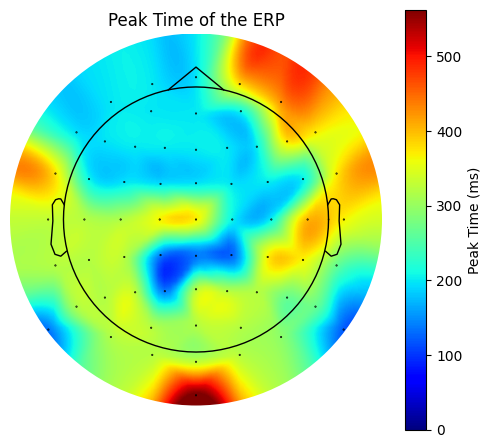

In [291]:
# b. 
times = evoked.times
# print('times:', times, 'times.shape', times.shape) # [0.         0.00390625, ..., 0.80078125], times.shape (206,)
max_values = []
max_times = []
for i in range(ERP.shape[0]):
    max_val = np.max(ERP[i, :])
    max_idx = np.argmax(ERP[i, :])
    max_values.append(max_val)
    max_times.append(times[max_idx])
max_values = np.array(max_values)
max_times = np.array(max_times) * 1000  # Convert to milliseconds

######################################################################
fig, ax = plt.subplots(figsize=(6,5))
im, _ = mne.viz.plot_topomap(max_times, evoked.info, cmap='jet', contours=0, axes=ax, show=False, size=3)
# Show colorbar
plt.colorbar(im, ax=ax, label='Peak Time (ms)')
plt.title("Peak Time of the ERP")
plt.show()


b. In the displayed figure, the color scheme indicates the timing of responses, where blue represents the earliest response and red represents the latest. Shades in between denote relative response timings based on their color intensity.
Upon examination, electrodes (Cpz, Cp2, Cp1, P1, P10, P9) exhibit the earliest response. This trend is also evident in the upper left section of the scalp. Conversely, electrodes like Iz, Fp2, Af8, and F8 show the latest response.
Additionally, below you can find the temporal average visualization for each electrode, presented separately

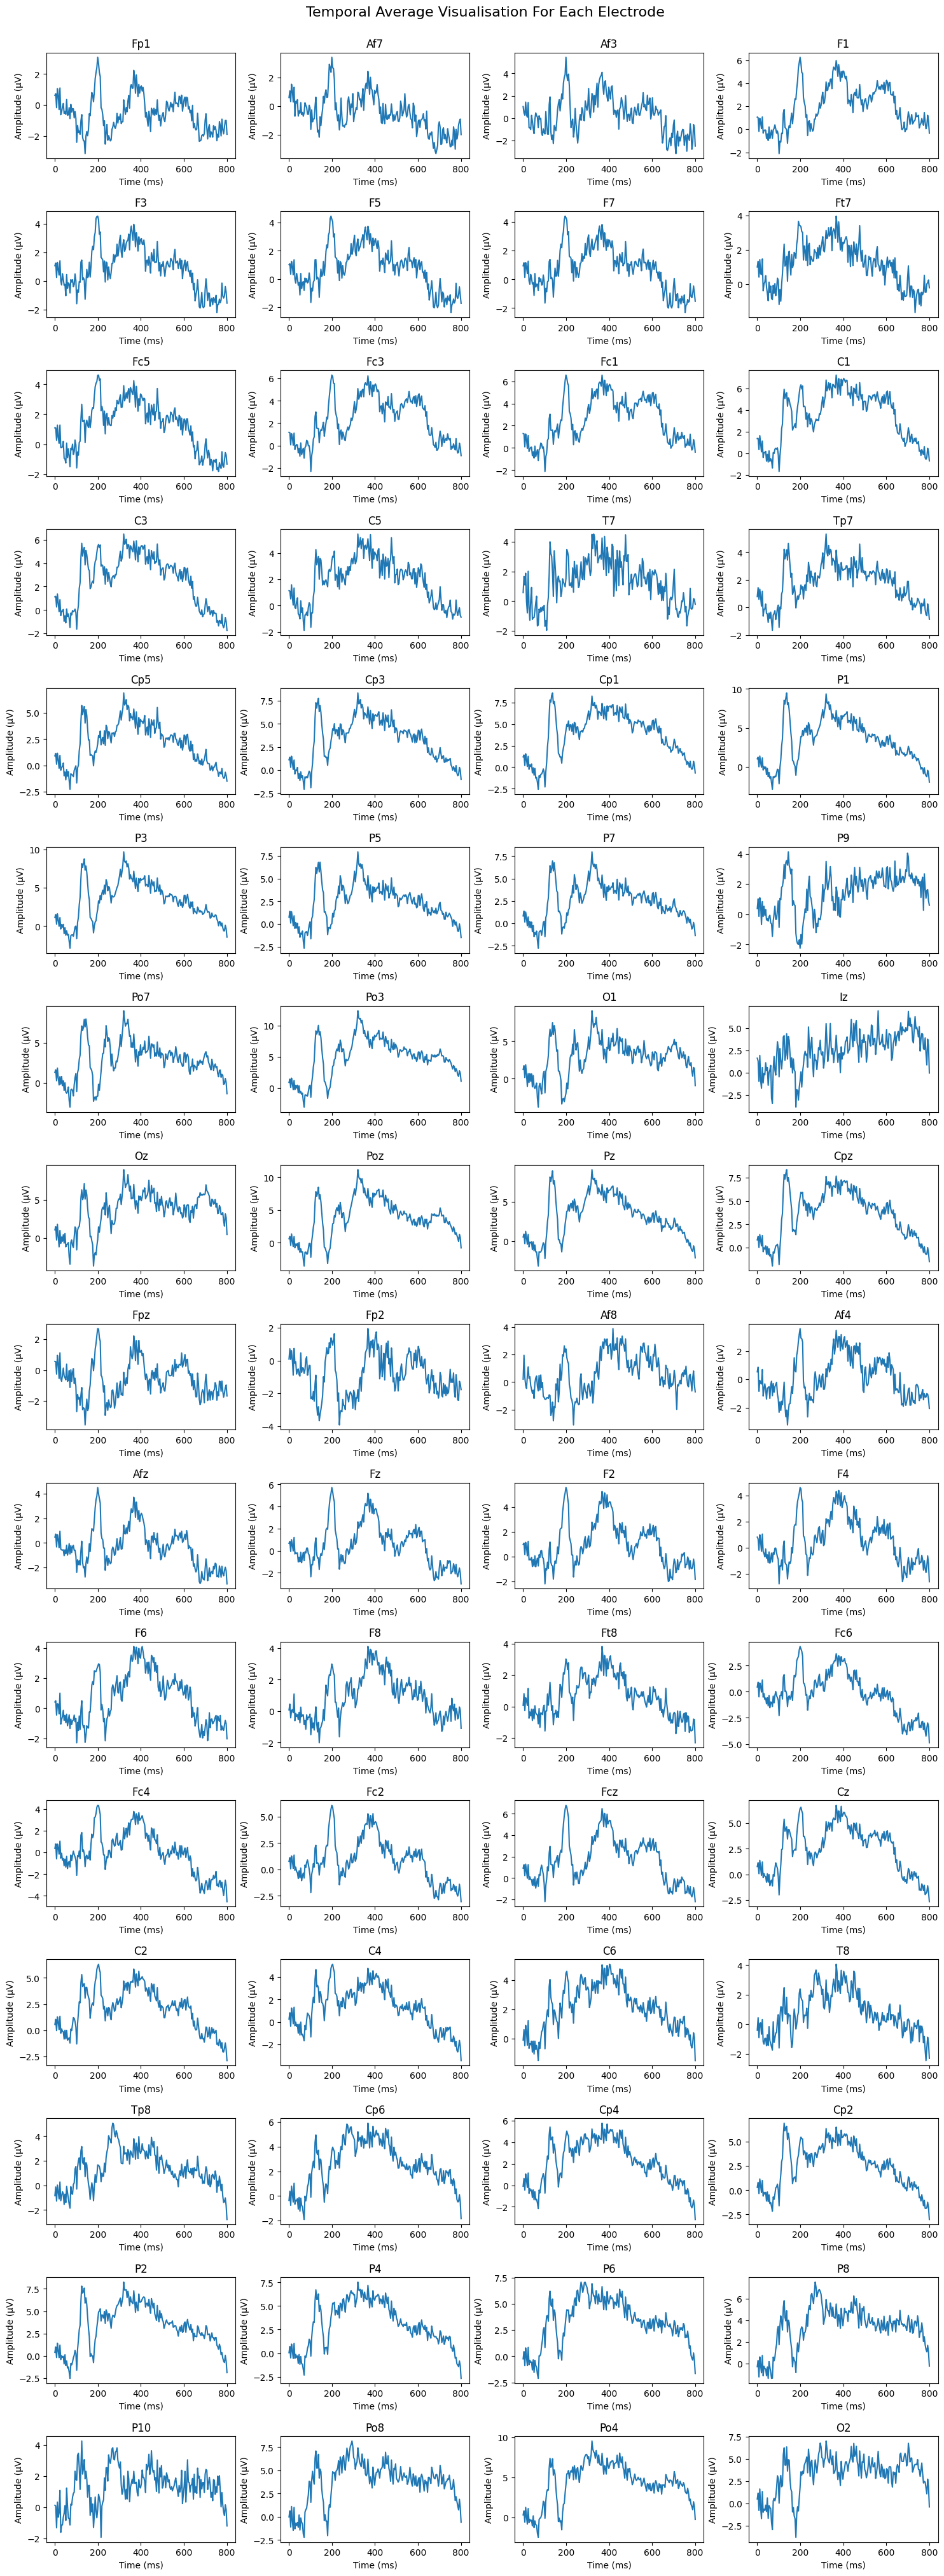

In [292]:
############
fig, axs = plt.subplots(nrows=16, ncols=4, figsize=(15, 40))
fig.tight_layout(pad=2.0)  # Adjust the spacing between subplots
fig.suptitle('Temporal Average Visualisation For Each Electrode', fontsize=16, y=1.01) 
# Flatten the axis array for easier indexing
axs = axs.ravel()
for idx in range(64):  # Loop through each channel
    # Plot the ERP data for the current channel over time
    axs[idx].plot(times * 1000, ERP[idx, :])
    axs[idx].set_title(evoked.ch_names[idx])  # Set title as channel name
    axs[idx].set_xlabel('Time (ms)')
    axs[idx].set_ylabel('Amplitude (µV)')
plt.subplots_adjust(hspace=0.5)
plt.show()

C:\Users\tnlab\AppData\Local\Temp\ipykernel_16184\2574989804.py:37: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.evoked.EvokedArray'>.tmin (0 s)
  avg_data_l = laplacian_raw.copy().crop(tmin=start_time, tmax=end_time).data.mean(axis=1)


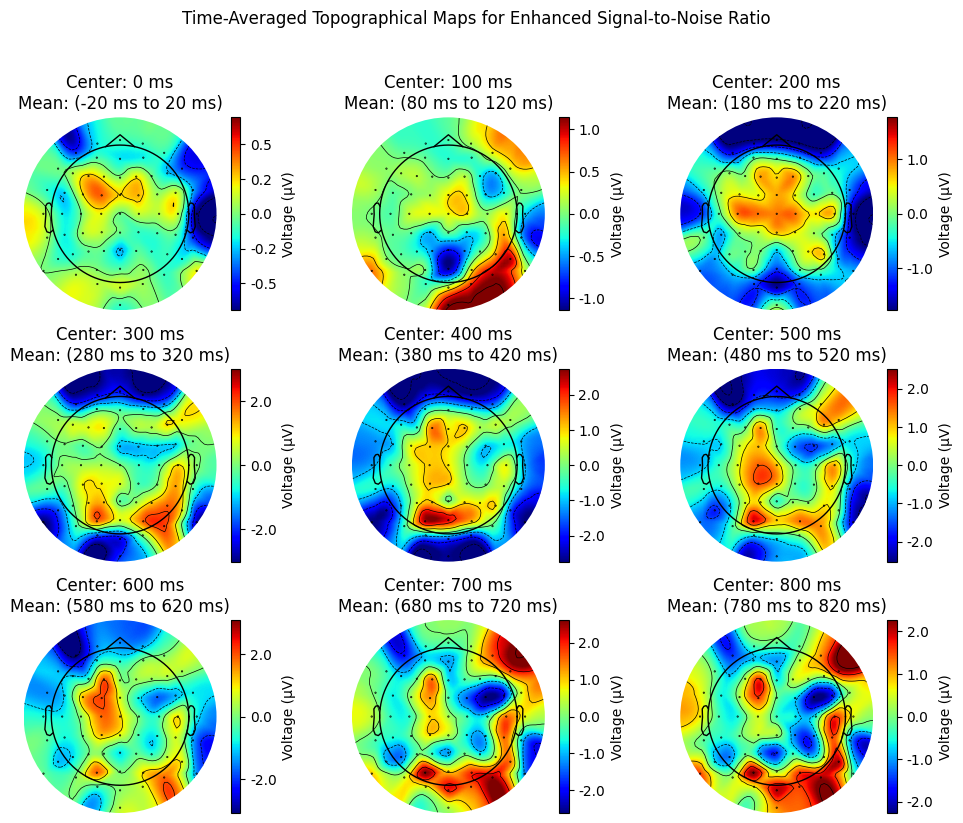

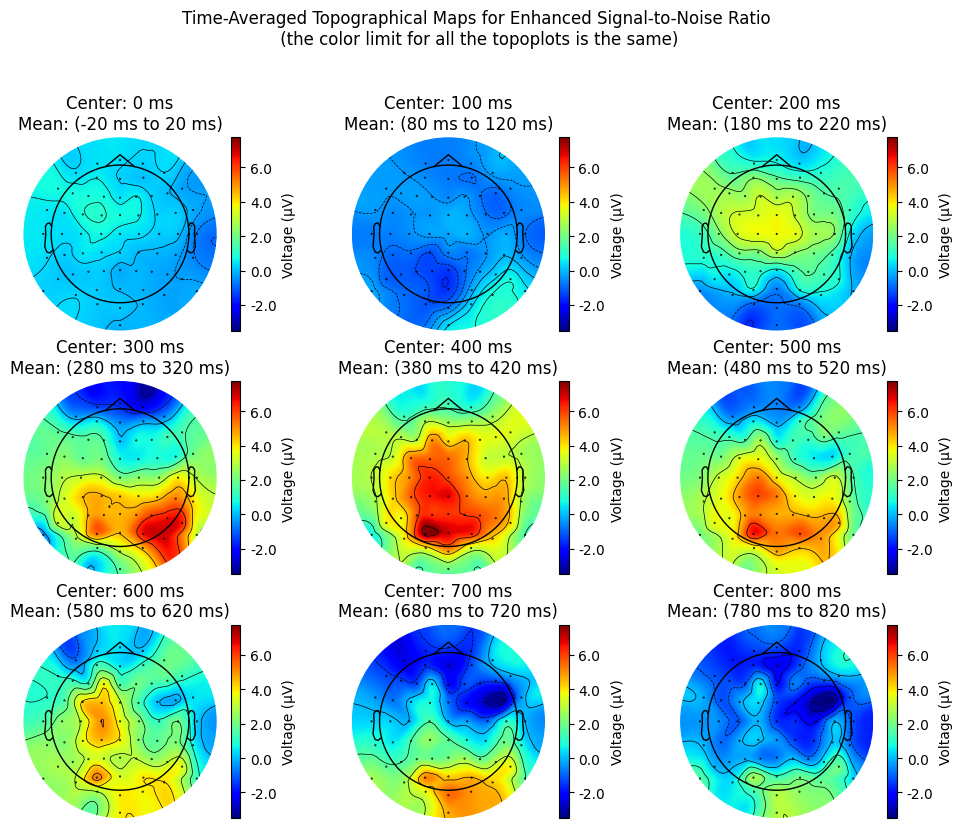

In [294]:
# c.
with open('eloc64C2.txt', 'r') as f_l:
    lines_l = f_l.readlines()
channel_names_l = [line_l.split()[3].replace('.', '') for line_l in lines_l[0:]] 
theta_l = np.array([float(line_l.split()[1]) for line_l in lines_l[0:]]) * np.pi / 180.0  
radius_l = np.array([float(line_l.split()[2]) for line_l in lines_l[0:]])
x_l = radius_l * np.cos(theta_l)
y_l = radius_l * np.sin(theta_l)
z_l = np.zeros_like(x_l)
radius_range = [0.18, 0.28]
laplacian_data = np.zeros_like(ERP_20)
for i in range(64):
    distances = np.sqrt((x_l - x_l[i]) ** 2 + (y_l - y_l[i]) ** 2)
    surrounding_indices = np.where((distances > radius_range[0]) & (distances < radius_range[1]))[0]
    if len(surrounding_indices) > 0:
        weights = 1 / distances[surrounding_indices]
        weights = weights / np.sum(weights)  # Normalize weights
    else:
        weights = np.array([])
    weights = weights[:, np.newaxis]
    if len(weights) > 0:
        laplacian_data[i, :] = ERP_20[i, :] - np.sum(weights * ERP_20[surrounding_indices, :], axis=0)
    else:
        laplacian_data[i, :] = ERP_20[i, :]
laplacian_raw = evoked_20.copy()
laplacian_raw._data = laplacian_data

########################################
plt.close('all')
center_times = np.linspace(0, .8, 9)  
fig, axs = plt.subplots(3, 3, figsize=(10,8))
fig.suptitle("Time-Averaged Topographical Maps for Enhanced Signal-to-Noise Ratio", fontsize=12, y=1.03)
AVE_ERP_l=[]
for idx, center_time in enumerate(center_times):
    start_time = center_time - 0.020
    end_time = center_time + 0.020
    avg_data_l = laplacian_raw.copy().crop(tmin=start_time, tmax=end_time).data.mean(axis=1)
    AVE_ERP_l.append(avg_data)
    ax = axs[idx // 3, idx % 3]
    im, _ = mne.viz.plot_topomap(avg_data_l, laplacian_raw.info, cmap='jet', axes=ax, show=False)
    fig.colorbar(im, ax=ax, format='%3.1f', orientation='vertical', label='Voltage (µV)') 
    ax.set_title(f"Center: {center_time*1000:.0f} ms\nMean: ({start_time*1000:.0f} ms to {end_time*1000:.0f} ms)")
plt.tight_layout()
plt.show()
AVE_ERP_np_l=np.array(AVE_ERP)

###################################################
plt.close('all')
center_times = np.linspace(0, .8, 9)  
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
fig.suptitle("Time-Averaged Topographical Maps for Enhanced Signal-to-Noise Ratio\n (the color limit for all the topoplots is the same)", fontsize=12, y=1.03)
global_vmin, global_vmax = AVE_ERP_np_l.min(), AVE_ERP_np_l.max()
for idx, center_time in enumerate(center_times):
    start_time = center_time - 0.020
    end_time = center_time + 0.020
    ax = axs[idx // 3, idx % 3]
    im, _ = mne.viz.plot_topomap(AVE_ERP_np_l[idx, :], laplacian_raw.info, cmap='jet', axes=ax, show=False)
    im.set_clim(global_vmin, global_vmax)
    fig.colorbar(im, ax=ax, format='%3.1f', orientation='vertical', label='Voltage (µV)')
    ax.set_title(f"Center: {center_time*1000:.0f} ms\nMean: ({start_time*1000:.0f} ms to {end_time*1000:.0f} ms)")
plt.tight_layout()
plt.show()

By implementing the large Laplacian filter, we significantly enhance the spatial precision of the EEG data. The Laplacian filter operates on the principle of spatial second derivatives, which emphasizes local changes in the signal. As a result, this technique sharpens the topographic representation of the electrical activity on the scalp, allowing for a more detailed and localized observation. When comparing the results from step (c) with those from step (a), it becomes evident that the Laplacian-filtered data provides a clearer distinction between active and non-active regions. This improved localization can be particularly beneficial in identifying focal brain activities and can aid in the interpretation of the underlying neural sources. Thus, the large Laplacian filter emerges as an essential tool for a more precise spatial analysis of EEG data